# SGD Regression Model - Hyperparameter Tuning

## Strategy:
- Use ALL 4 features for maximum prediction accuracy
- Grid search hyperparameters: learning_rate, penalty, alpha, eta0
- Extensive visualization and analysis

# WOW cv 10 really changes the graphs from cv3!!

Data shape: (9568, 5)
Checking for duplicate feature combinations...
Rows with duplicate features: 82
Groups with same output: 41
Groups with different outputs: 0
Safe to remove duplicates - same features have same outputs
After removing duplicates: (9527, 5)

Missing values:
ambient_temp         0
vacuum               0
ambient_pressure     0
relative_humidity    0
power_output         0
dtype: int64

Data types:
ambient_temp         float64
vacuum               float64
ambient_pressure     float64
relative_humidity    float64
power_output         float64
dtype: object
Feature statistics:
       ambient_temp       vacuum  ambient_pressure  relative_humidity
count   9527.000000  9527.000000       9527.000000        9527.000000
mean      19.658225    54.293421       1013.237084          73.334951
std        7.444397    12.686309          5.940526          14.607513
min        1.810000    25.360000        992.890000          25.560000
25%       13.530000    41.740000       1009.085000   

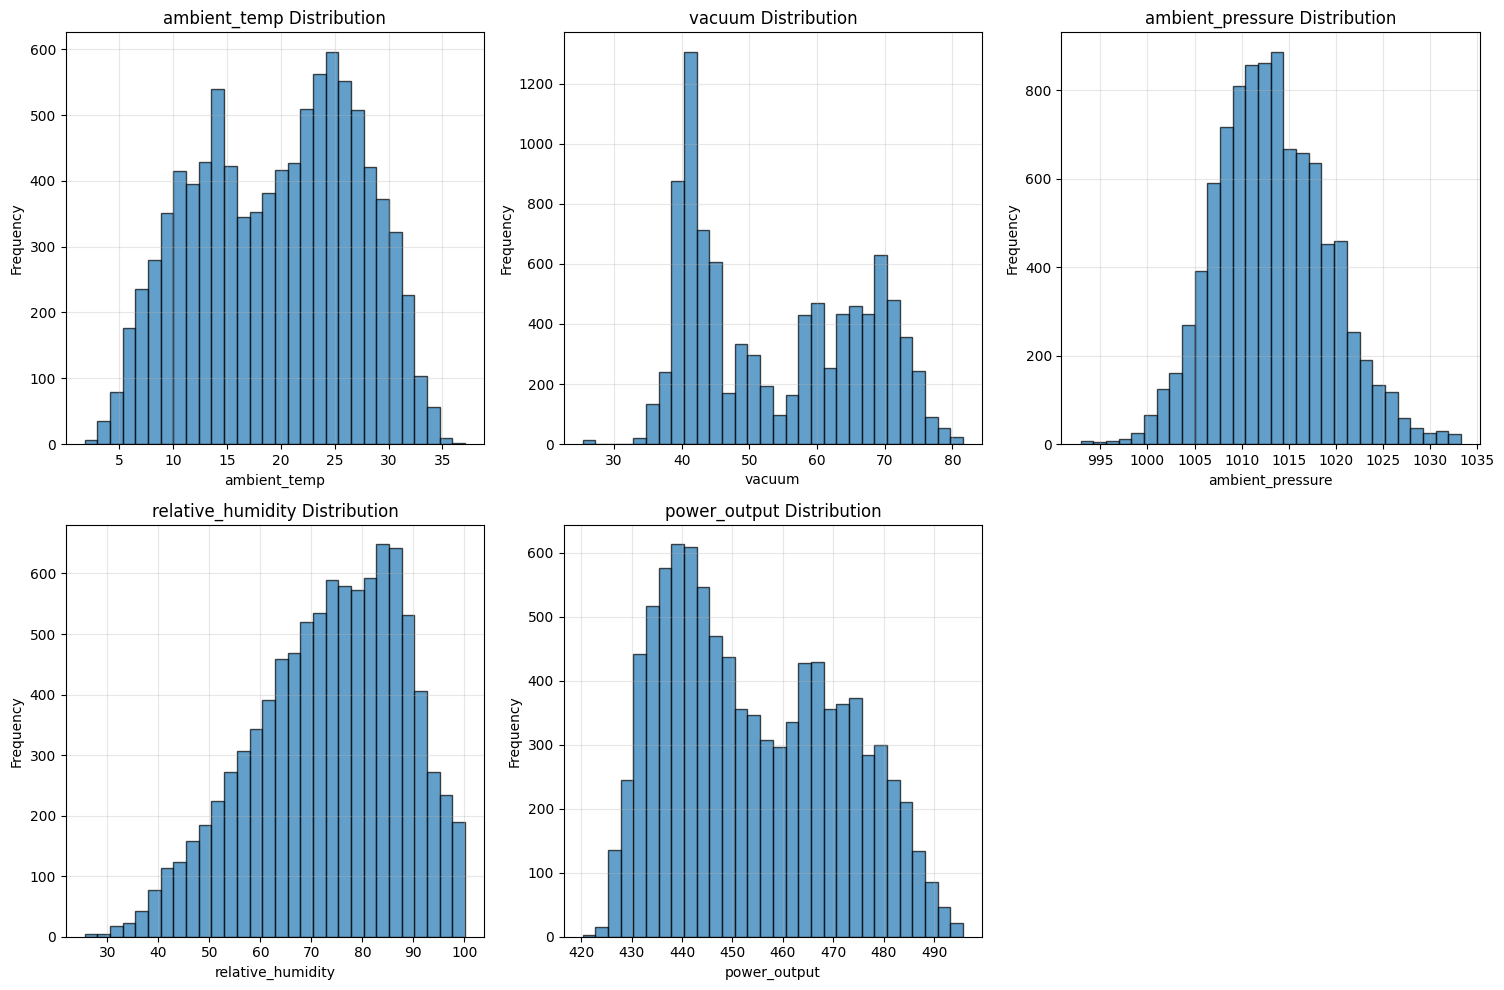

STANDARDIZATION ANALYSIS:
Feature scales (before standardization):
ambient_temp        : mean=   19.7, std=  7.4, range= 35.3
vacuum              : mean=   54.3, std= 12.7, range= 56.2
ambient_pressure    : mean= 1013.2, std=  5.9, range= 40.4
relative_humidity   : mean=   73.3, std= 14.6, range= 74.6

After standardization:
ambient_temp        : mean=-0.0000, std=1.0001
vacuum              : mean=-0.0000, std=1.0001
ambient_pressure    : mean= 0.0000, std=1.0001
relative_humidity   : mean=-0.0000, std=1.0001

Why standardization is essential:
- Different units: °C, cm Hg, millibar, %
- Different scales: prevent feature dominance
- SGD sensitivity: ensures equal gradient contribution
- OLS stability: fixes numerical condition issues


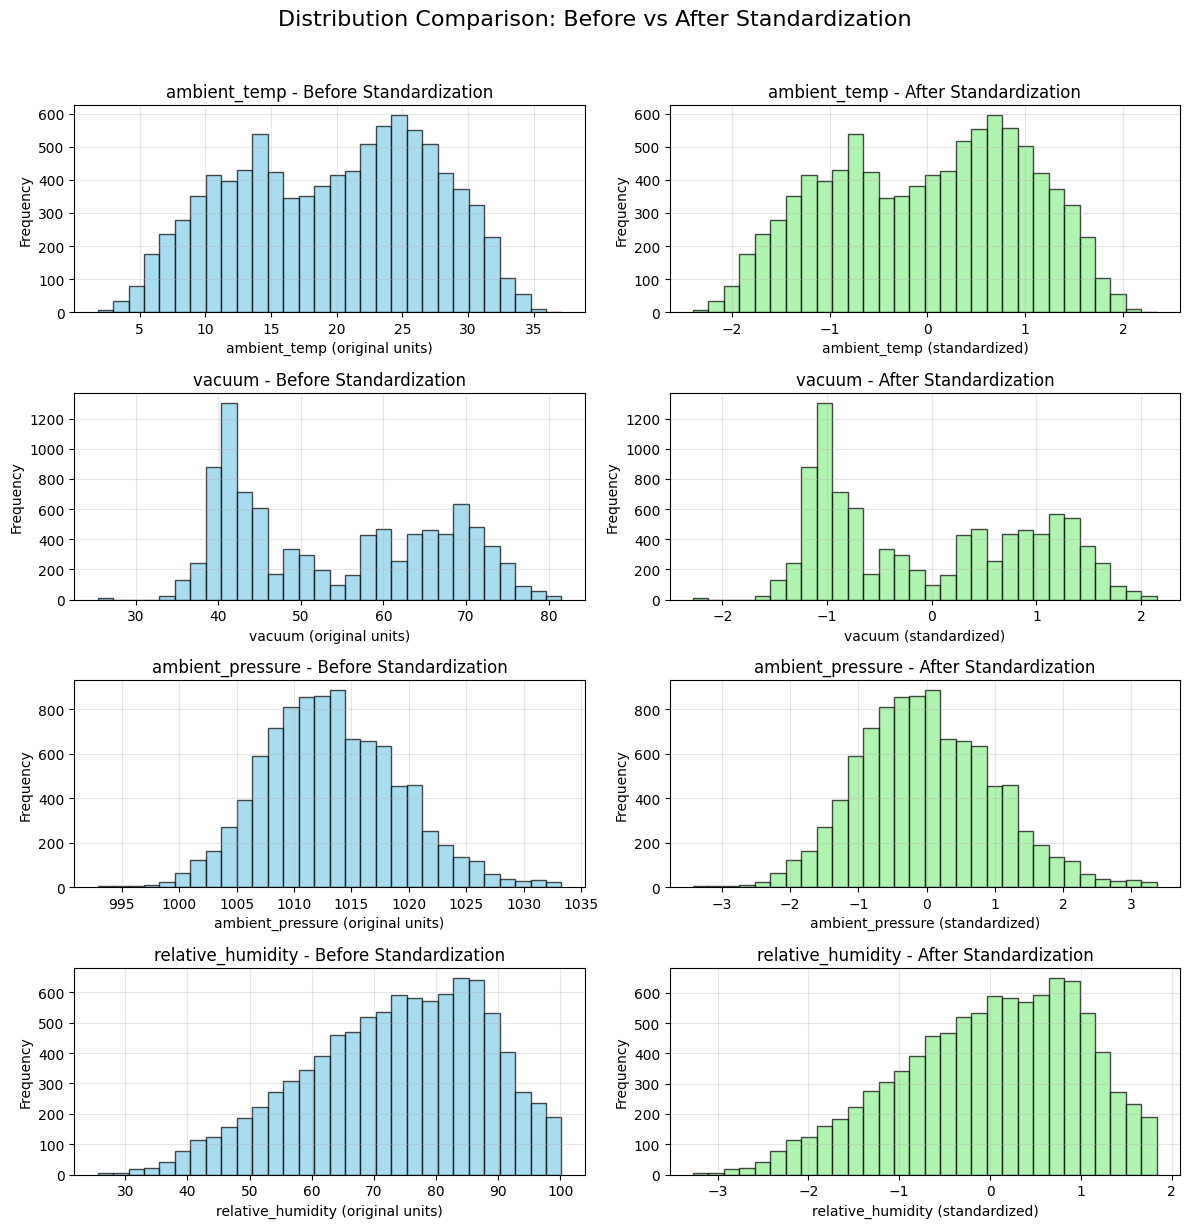

Feature-Target Correlations:
ambient_temp: -0.948
vacuum: -0.870
ambient_pressure: +0.519
relative_humidity: +0.391

Feature-Feature Correlations:
ambient_temp - vacuum: 0.844
ambient_temp - ambient_pressure: -0.508
vacuum - ambient_pressure: -0.416
High correlation (>0.7) indicates multicollinearity problem


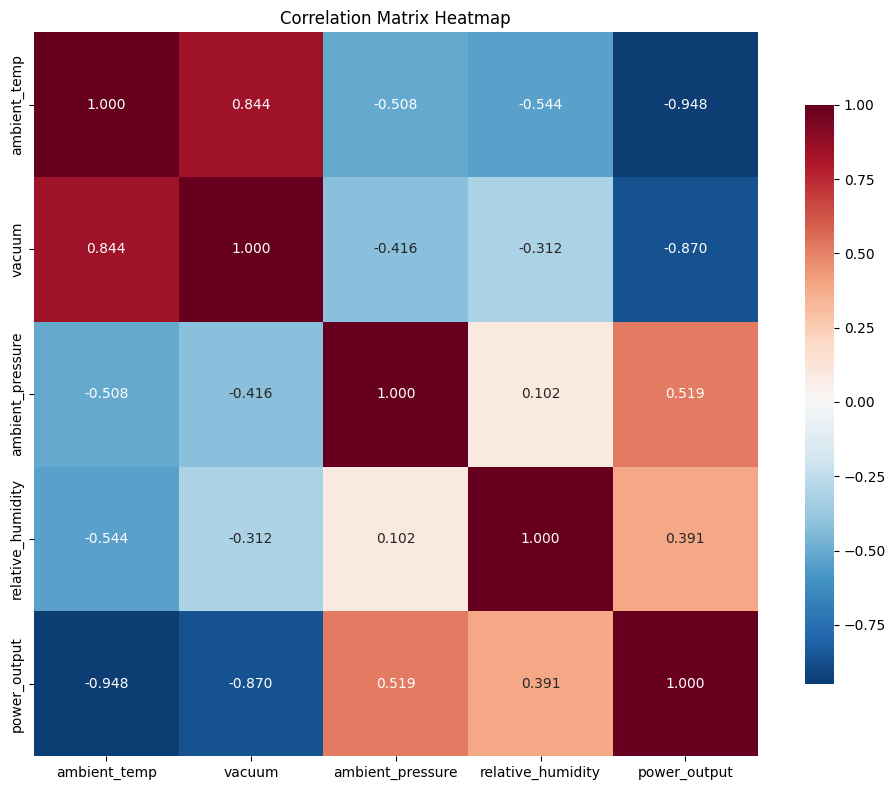

Testing all possible feature combinations:
------------------------------------------------------------
Top 10 feature combinations (by test R²):
 1. [4 features] Test R²=0.9284 | ambient_temp, vacuum, ambient_pressure, relative_humidity
 2. [3 features] Test R²=0.9282 | ambient_temp, vacuum, relative_humidity
 3. [3 features] Test R²=0.9209 | ambient_temp, ambient_pressure, relative_humidity
 4. [2 features] Test R²=0.9209 | ambient_temp, relative_humidity
 5. [3 features] Test R²=0.9179 | ambient_temp, vacuum, ambient_pressure
 6. [2 features] Test R²=0.9164 | ambient_temp, vacuum
 7. [2 features] Test R²=0.9013 | ambient_temp, ambient_pressure
 8. [1 features] Test R²=0.9000 | ambient_temp
 9. [3 features] Test R²=0.8106 | vacuum, ambient_pressure, relative_humidity
10. [2 features] Test R²=0.7960 | vacuum, ambient_pressure

Best combination: ['ambient_temp', 'vacuum', 'ambient_pressure', 'relative_humidity']
Best test R²: 0.9284
TRUSTWORTHY FEATURE ANALYSIS FOR OLS:
All feature com

In [3]:
# Import all necessary libraries for SGD modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Load preprocessing results from preprocessing.ipynb
%run preprocessing.ipynb
print("Preprocessing complete. Data ready for modeling.")

# Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Verify we have the key variables available
print(f"\nVerifying data availability:")
print(f"- Data shape: {data.shape}")
print(f"- Features: {features}")
print(f"- Target: {target}")
print(f"- Standardized features shape: {X_standardized.shape}")
print(f"- All variables loaded successfully!")

In [42]:
# Define comprehensive hyperparameter grid with reasonable U-shape demonstration
# Use moderate extreme values to show performance curves without numerical instability
param_grid = {
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'penalty': ['elasticnet', 'l1', 'l2'],
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
    'eta0': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
    print(f"{param}: {len(values)} options -> {values}")

total_experiments = total_combinations * 10
print(f"\n" + "="*50)
print(f"STABLE HYPERPARAMETER SEARCH SUMMARY:")
print(f"- Parameter combinations: {total_combinations}")
print(f"- CV folds: 10")
print(f"- Total models to train: {total_experiments}")
print(f"- Strategy: Comprehensive exploration with stable ranges")
print(f"- Fixed: Removed extreme values causing numerical instability")
print(f"- Expected: Clear performance curves without convergence failures")
print(f"="*50)

learning_rate: 3 options -> ['constant', 'optimal', 'adaptive']
penalty: 3 options -> ['elasticnet', 'l1', 'l2']
alpha: 7 options -> [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
eta0: 7 options -> [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

STABLE HYPERPARAMETER SEARCH SUMMARY:
- Parameter combinations: 441
- CV folds: 10
- Total models to train: 4410
- Strategy: Comprehensive exploration with stable ranges
- Fixed: Removed extreme values causing numerical instability
- Expected: Clear performance curves without convergence failures


In [43]:
# GridSearchCV implementation with 10-fold cross-validation
print("\nStarting comprehensive SGD hyperparameter search...")
print(f"Total parameter combinations: {total_combinations}")
print(f"With 10-fold CV: {total_combinations * 10} model fits")

# Setup 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# Initialize SGD regressor
sgd = SGDRegressor(max_iter=300, random_state=RANDOM_SEED, early_stopping=True, validation_fraction=0.1)

# Setup GridSearchCV with multiple scoring metrics
scoring = {
    'r2': 'r2',
    'rmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

print("\nInitializing GridSearchCV...")
grid_search = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='r2',  # Refit on R² score
    return_train_score=True,
    n_jobs=-1,  # Use all available cores
    verbose=1   # Show progress
)

# Fit the grid search on standardized data
print("\nExecuting grid search (this may take a few minutes)...")
start_time = time.time()
grid_search.fit(X_standardized, y)
end_time = time.time()

print(f"\nGrid search completed in {end_time - start_time:.1f} seconds")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")


Starting comprehensive SGD hyperparameter search...
Total parameter combinations: 441
With 10-fold CV: 4410 model fits

Initializing GridSearchCV...

Executing grid search (this may take a few minutes)...
Fitting 10 folds for each of 441 candidates, totalling 4410 fits

Grid search completed in 27.1 seconds
Best parameters found: {'alpha': 0.0005, 'eta0': 0.001, 'learning_rate': 'constant', 'penalty': 'elasticnet'}
Best cross-validation R² score: 0.9283


In [44]:
# Extract and analyze comprehensive results
print("\n" + "="*60)
print("COMPREHENSIVE SGD RESULTS ANALYSIS")
print("="*60)

# Convert GridSearchCV results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Check what columns are available
print("Available columns in cv_results_:")
print([col for col in results_df.columns if 'test' in col])
print()

# Convert negative scores to positive for RMSE and MAE
results_df['mean_test_rmse'] = np.sqrt(-results_df['mean_test_rmse'])
results_df['std_test_rmse'] = results_df['std_test_rmse'] / 2  # Approximate std for RMSE
results_df['mean_test_mae'] = -results_df['mean_test_mae']
results_df['std_test_mae'] = -results_df['std_test_mae']

# Add train RMSE and MAE
results_df['mean_train_rmse'] = np.sqrt(-results_df['mean_train_rmse'])
results_df['mean_train_mae'] = -results_df['mean_train_mae']

# Calculate cross-validation consistency (coefficient of variation)
results_df['r2_cv_consistency'] = results_df['std_test_r2'] / results_df['mean_test_r2']
results_df['rmse_cv_consistency'] = results_df['std_test_rmse'] / results_df['mean_test_rmse']

# Overall performance statistics
print("\n1. OVERALL PERFORMANCE STATISTICS:")
print(f"Total parameter combinations tested: {len(results_df)}")
print(f"\nValidation R² Statistics:")
print(f"  Mean ± Std: {results_df['mean_test_r2'].mean():.4f} ± {results_df['mean_test_r2'].std():.4f}")
print(f"  Range: [{results_df['mean_test_r2'].min():.4f}, {results_df['mean_test_r2'].max():.4f}]")
print(f"\nValidation RMSE Statistics:")
print(f"  Mean ± Std: {results_df['mean_test_rmse'].mean():.2f} ± {results_df['mean_test_rmse'].std():.2f}")
print(f"  Range: [{results_df['mean_test_rmse'].min():.2f}, {results_df['mean_test_rmse'].max():.2f}]")
print(f"\nValidation MAE Statistics:")
print(f"  Mean ± Std: {results_df['mean_test_mae'].mean():.2f} ± {results_df['mean_test_mae'].std():.2f}")
print(f"  Range: [{results_df['mean_test_mae'].min():.2f}, {results_df['mean_test_mae'].max():.2f}]")

# Individual parameter analysis
print("\n2. INDIVIDUAL PARAMETER ANALYSIS:")

# Learning Rate Analysis
print("\n2.1 LEARNING RATE ANALYSIS:")
lr_analysis = results_df.groupby('param_learning_rate').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(lr_analysis)

# Penalty Analysis
print("\n2.2 PENALTY ANALYSIS:")
penalty_analysis = results_df.groupby('param_penalty').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(penalty_analysis)

# Alpha Analysis
print("\n2.3 ALPHA (REGULARIZATION) ANALYSIS:")
alpha_analysis = results_df.groupby('param_alpha').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(alpha_analysis)

# Eta0 Analysis
print("\n2.4 ETA0 (INITIAL LEARNING RATE) ANALYSIS:")
eta0_analysis = results_df.groupby('param_eta0').agg({
    'mean_test_r2': ['count', 'mean', 'std', 'min', 'max'],
    'mean_test_rmse': ['mean', 'std'],
    'mean_test_mae': ['mean', 'std'],
    'r2_cv_consistency': 'mean',
    'mean_fit_time': 'mean'
}).round(4)
print(eta0_analysis)

# Cross-validation consistency analysis
print("\n3. CROSS-VALIDATION CONSISTENCY ANALYSIS:")
print("\nAll 81 parameter combinations ranked by validation R² (top 20):")
top_performers = results_df.nlargest(20, 'mean_test_r2')[['params', 'mean_test_r2', 'std_test_r2', 
                                                         'mean_test_rmse', 'r2_cv_consistency', 'mean_fit_time']]
for idx, row in top_performers.iterrows():
    print(f"{idx+1:2d}. R²={row['mean_test_r2']:.4f}±{row['std_test_r2']:.4f} | "
          f"RMSE={row['mean_test_rmse']:.2f} | CV={row['r2_cv_consistency']:.4f} | "
          f"Time={row['mean_fit_time']:.2f}s | {row['params']}")

print("\nMost consistent parameter combinations (lowest CV, top 10):")
most_consistent = results_df.nsmallest(10, 'r2_cv_consistency')[['params', 'mean_test_r2', 'std_test_r2', 
                                                                 'r2_cv_consistency']]
for idx, row in most_consistent.iterrows():
    print(f"{idx+1:2d}. CV={row['r2_cv_consistency']:.4f} | R²={row['mean_test_r2']:.4f}±{row['std_test_r2']:.4f} | {row['params']}")

# Parameter interaction analysis
print("\n4. PARAMETER INTERACTION ANALYSIS:")

# Create interaction matrices
interaction_data = results_df.copy()

print("\n4.1 Learning Rate × Penalty Interaction:")
lr_penalty = interaction_data.groupby(['param_learning_rate', 'param_penalty'])['mean_test_r2'].agg(['mean', 'std']).round(4)
print(lr_penalty)

print("\n4.2 Alpha × Eta0 Interaction:")
alpha_eta0 = interaction_data.groupby(['param_alpha', 'param_eta0'])['mean_test_r2'].agg(['mean', 'std']).round(4)
print(alpha_eta0)

print("\n4.3 Learning Rate × Alpha Interaction:")
lr_alpha = interaction_data.groupby(['param_learning_rate', 'param_alpha'])['mean_test_r2'].agg(['mean', 'std']).round(4)
print(lr_alpha)

# Training vs validation performance analysis
print("\n5. TRAINING VS VALIDATION PERFORMANCE ANALYSIS:")
print("\nOverfitting analysis (train R² - validation R²):")
results_df['overfitting'] = results_df['mean_train_r2'] - results_df['mean_test_r2']
overfitting_stats = results_df['overfitting'].describe()
print(f"Mean overfitting: {overfitting_stats['mean']:.4f}")
print(f"Std overfitting:  {overfitting_stats['std']:.4f}")
print(f"Max overfitting:  {overfitting_stats['max']:.4f}")
print(f"Min overfitting:  {overfitting_stats['min']:.4f}")

print("\nTop 5 models with least overfitting:")
least_overfitting = results_df.nsmallest(5, 'overfitting')[['params', 'mean_train_r2', 'mean_test_r2', 'overfitting']]
for idx, row in least_overfitting.iterrows():
    print(f"{idx+1}. Train R²={row['mean_train_r2']:.4f}, Val R²={row['mean_test_r2']:.4f}, "
          f"Diff={row['overfitting']:.4f} | {row['params']}")

print(f"\n" + "="*60)
print(f"ANALYSIS COMPLETE - {len(results_df)} models analyzed")
print(f"Best overall R² score: {results_df['mean_test_r2'].max():.4f}")
print(f"Most consistent model CV: {results_df['r2_cv_consistency'].min():.4f}")
print(f"="*60)


COMPREHENSIVE SGD RESULTS ANALYSIS
Available columns in cv_results_:
['split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse', 'split5_test_rmse', 'split6_test_rmse', 'split7_test_rmse', 'split8_test_rmse', 'split9_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'split5_test_mae', 'split6_test_mae', 'split7_test_mae', 'split8_test_mae', 'split9_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae']


1. OVERALL PERFORMANCE STATISTICS:
Total parameter combinations tested: 441

Validation R² Statistics:
  Mean ± Std: 0.1432 ± 5.9566
  Range: [-46.6857, 0.9283]

Validation RMSE Statistics:
  Mean ± Std: 6.8

Generating comprehensive performance visualizations...


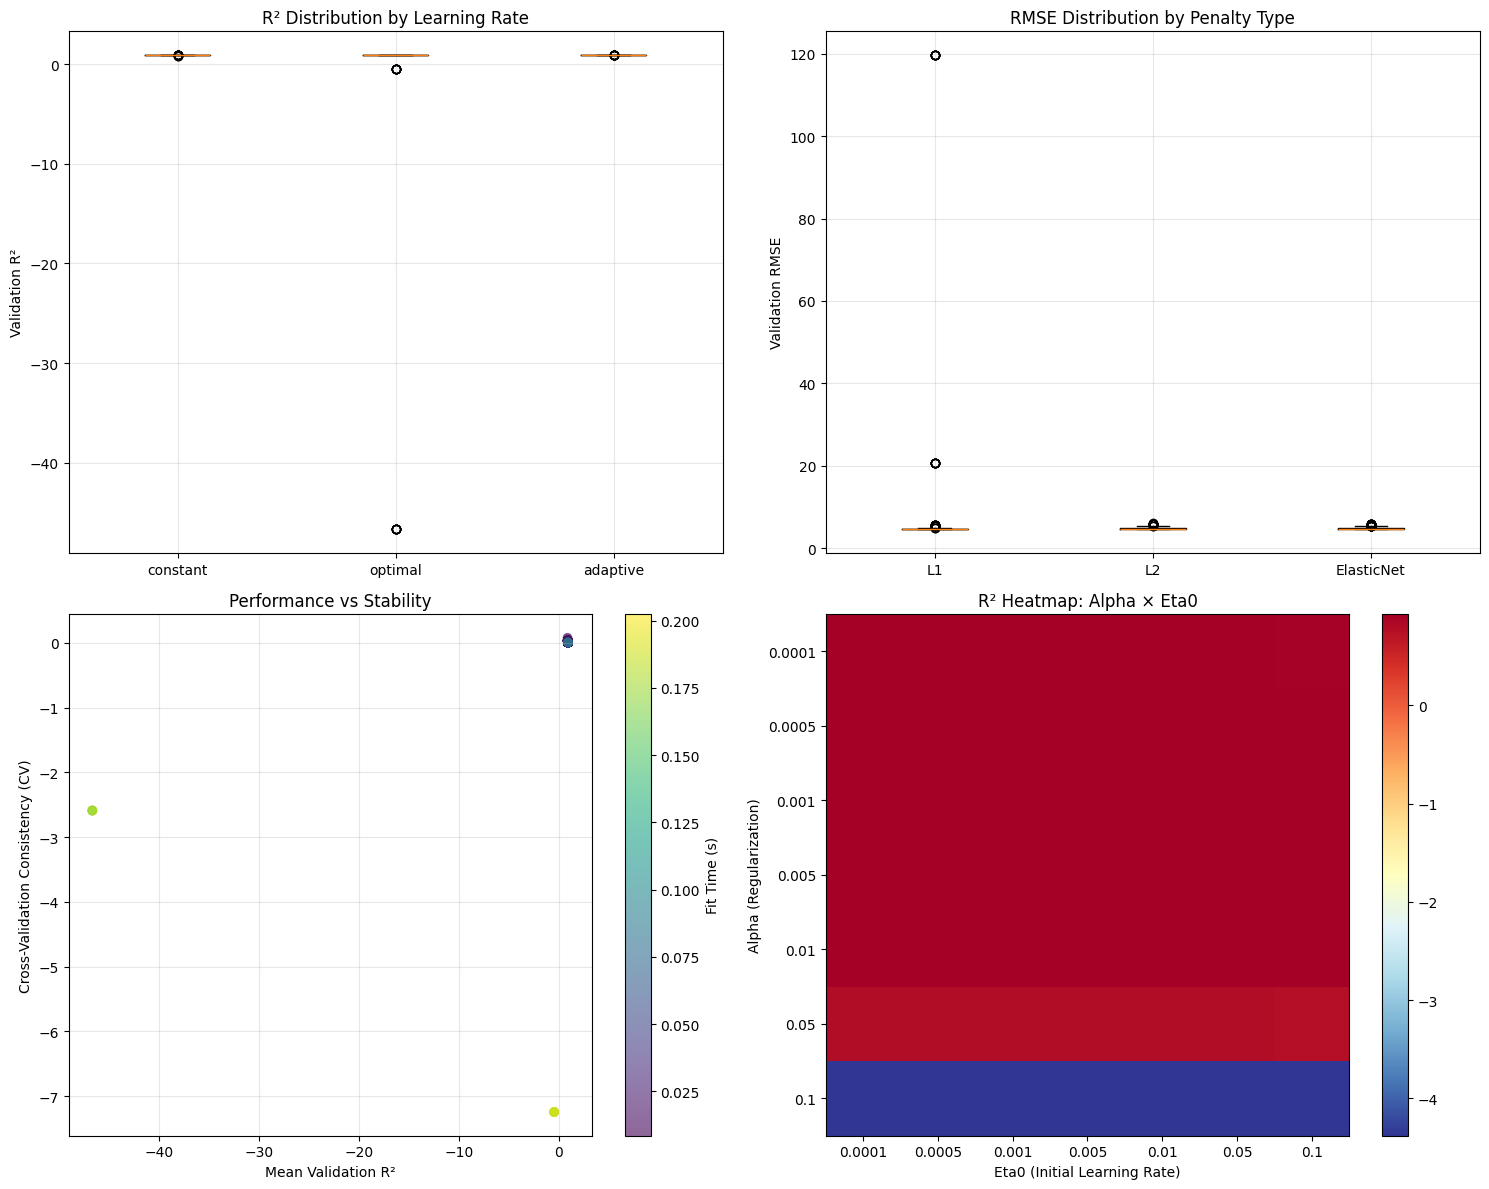

In [45]:
# Visualization 1 - Performance across parameters
print("Generating comprehensive performance visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: R² distribution by learning rate
lr_data = [results_df[results_df['param_learning_rate'] == lr]['mean_test_r2'].values 
           for lr in ['constant', 'optimal', 'adaptive']]
axes[0,0].boxplot(lr_data, labels=['constant', 'optimal', 'adaptive'])
axes[0,0].set_title('R² Distribution by Learning Rate')
axes[0,0].set_ylabel('Validation R²')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: RMSE distribution by penalty
penalty_data = [results_df[results_df['param_penalty'] == penalty]['mean_test_rmse'].values 
                for penalty in ['l1', 'l2', 'elasticnet']]
axes[0,1].boxplot(penalty_data, labels=['L1', 'L2', 'ElasticNet'])
axes[0,1].set_title('RMSE Distribution by Penalty Type')
axes[0,1].set_ylabel('Validation RMSE')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Performance stability (CV consistency)
axes[1,0].scatter(results_df['mean_test_r2'], results_df['r2_cv_consistency'], 
                  alpha=0.6, c=results_df['mean_fit_time'], cmap='viridis')
axes[1,0].set_xlabel('Mean Validation R²')
axes[1,0].set_ylabel('Cross-Validation Consistency (CV)')
axes[1,0].set_title('Performance vs Stability')
axes[1,0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1,0].collections[0], ax=axes[1,0])
cbar.set_label('Fit Time (s)')

# Plot 4: Alpha vs Eta0 performance heatmap
alpha_eta0_pivot = results_df.pivot_table(values='mean_test_r2', 
                                          index='param_alpha', 
                                          columns='param_eta0', 
                                          aggfunc='mean')
im = axes[1,1].imshow(alpha_eta0_pivot.values, cmap='RdYlBu_r', aspect='auto')
axes[1,1].set_xticks(range(len(alpha_eta0_pivot.columns)))
axes[1,1].set_yticks(range(len(alpha_eta0_pivot.index)))
axes[1,1].set_xticklabels(alpha_eta0_pivot.columns)
axes[1,1].set_yticklabels(alpha_eta0_pivot.index)
axes[1,1].set_xlabel('Eta0 (Initial Learning Rate)')
axes[1,1].set_ylabel('Alpha (Regularization)')
axes[1,1].set_title('R² Heatmap: Alpha × Eta0')
plt.colorbar(im, ax=axes[1,1])

plt.tight_layout()
plt.show()

Generating parameter interaction visualizations...


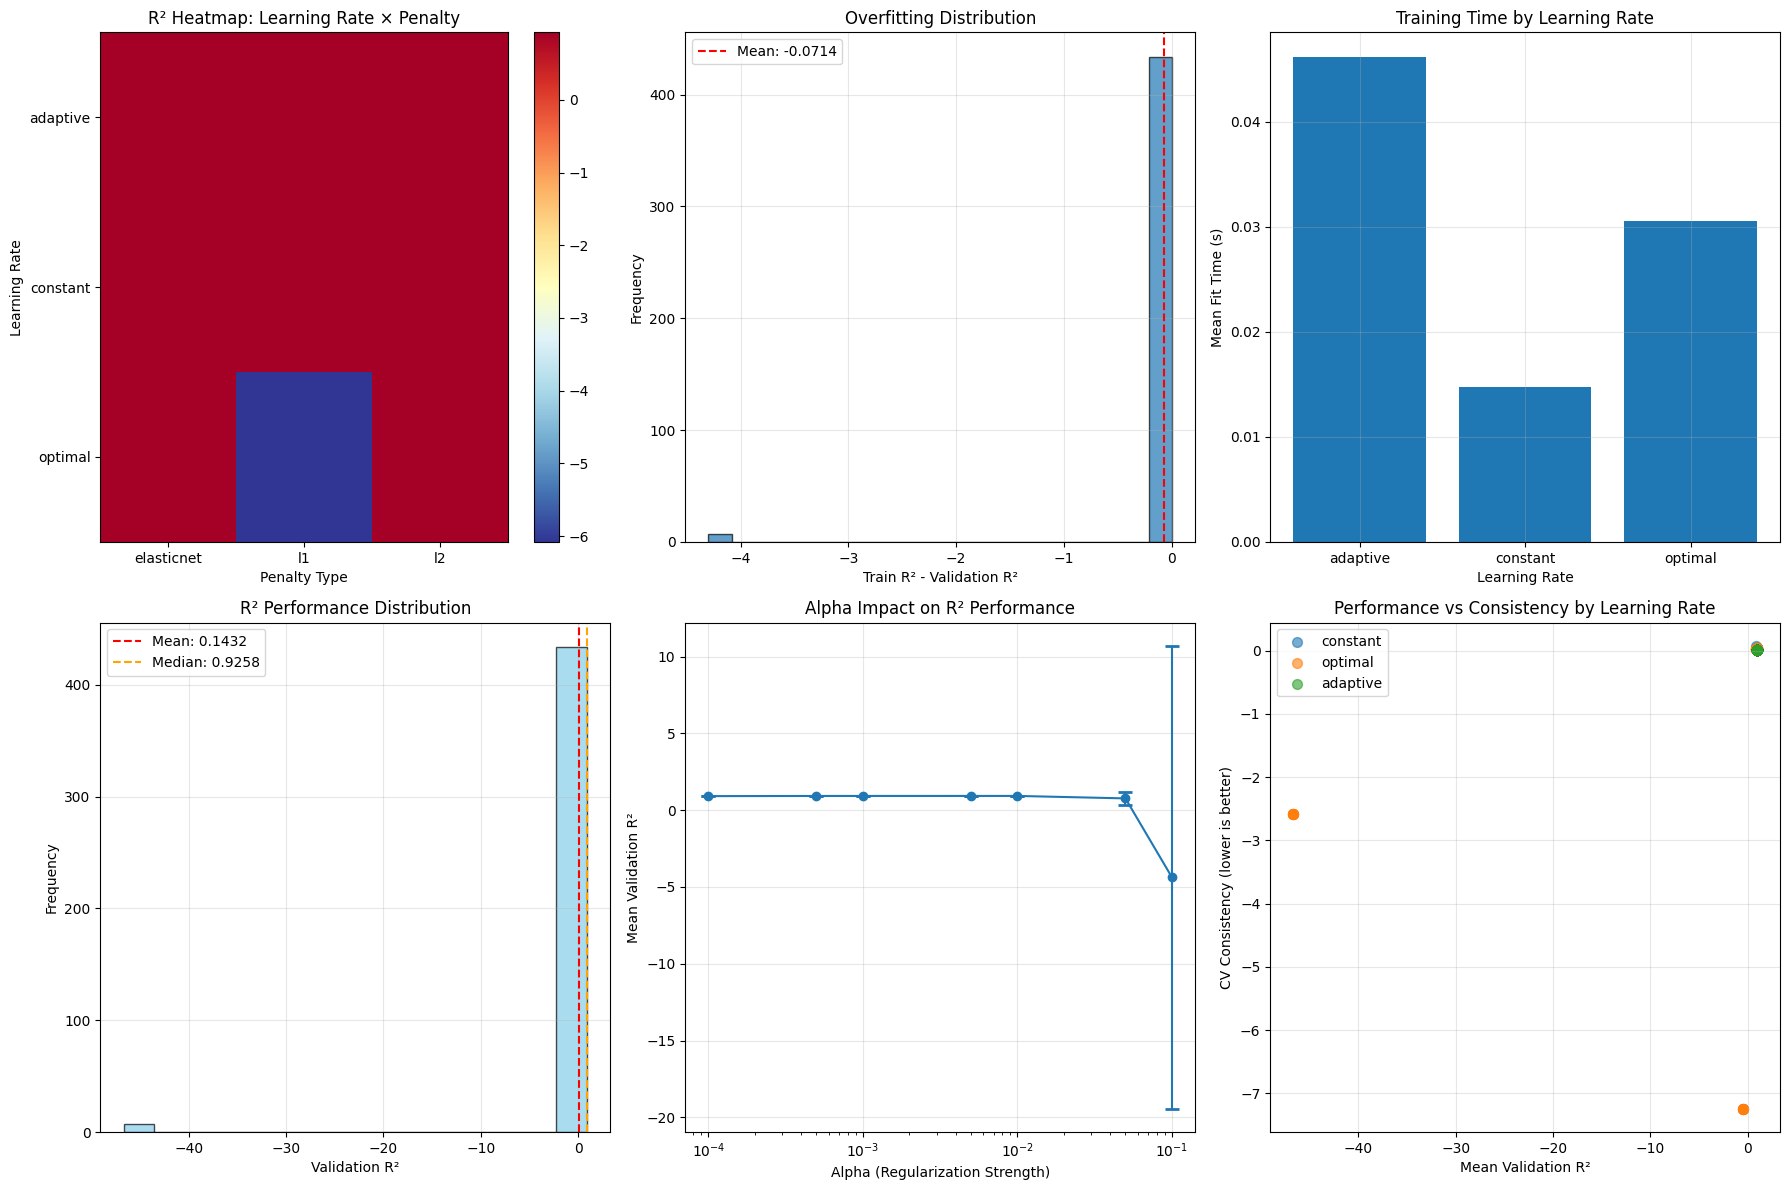

In [46]:
# Visualization 2 - Parameter interactions and detailed analysis
print("Generating parameter interaction visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Learning Rate vs Penalty interaction
lr_penalty_pivot = results_df.pivot_table(values='mean_test_r2', 
                                          index='param_learning_rate', 
                                          columns='param_penalty', 
                                          aggfunc='mean')
im1 = axes[0,0].imshow(lr_penalty_pivot.values, cmap='RdYlBu_r', aspect='auto')
axes[0,0].set_xticks(range(len(lr_penalty_pivot.columns)))
axes[0,0].set_yticks(range(len(lr_penalty_pivot.index)))
axes[0,0].set_xticklabels(lr_penalty_pivot.columns)
axes[0,0].set_yticklabels(lr_penalty_pivot.index)
axes[0,0].set_xlabel('Penalty Type')
axes[0,0].set_ylabel('Learning Rate')
axes[0,0].set_title('R² Heatmap: Learning Rate × Penalty')
plt.colorbar(im1, ax=axes[0,0])

# Plot 2: Overfitting analysis
train_val_diff = results_df['mean_train_r2'] - results_df['mean_test_r2']
axes[0,1].hist(train_val_diff, bins=20, alpha=0.7, edgecolor='black')
axes[0,1].axvline(train_val_diff.mean(), color='red', linestyle='--', 
                  label=f'Mean: {train_val_diff.mean():.4f}')
axes[0,1].set_xlabel('Train R² - Validation R²')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Overfitting Distribution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Fit time analysis by parameters
fit_time_by_lr = results_df.groupby('param_learning_rate')['mean_fit_time'].mean()
axes[0,2].bar(fit_time_by_lr.index, fit_time_by_lr.values)
axes[0,2].set_xlabel('Learning Rate')
axes[0,2].set_ylabel('Mean Fit Time (s)')
axes[0,2].set_title('Training Time by Learning Rate')
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Performance distribution histogram
axes[1,0].hist(results_df['mean_test_r2'], bins=15, alpha=0.7, edgecolor='black', color='skyblue')
axes[1,0].axvline(results_df['mean_test_r2'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {results_df["mean_test_r2"].mean():.4f}')
axes[1,0].axvline(results_df['mean_test_r2'].median(), color='orange', linestyle='--', 
                  label=f'Median: {results_df["mean_test_r2"].median():.4f}')
axes[1,0].set_xlabel('Validation R²')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('R² Performance Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Alpha impact on performance
alpha_performance = results_df.groupby('param_alpha').agg({
    'mean_test_r2': ['mean', 'std'],
    'mean_test_rmse': ['mean', 'std']
}).round(4)
alphas = alpha_performance.index
r2_means = alpha_performance[('mean_test_r2', 'mean')]
r2_stds = alpha_performance[('mean_test_r2', 'std')]

axes[1,1].errorbar(alphas, r2_means, yerr=r2_stds, marker='o', capsize=5, capthick=2)
axes[1,1].set_xlabel('Alpha (Regularization Strength)')
axes[1,1].set_ylabel('Mean Validation R²')
axes[1,1].set_title('Alpha Impact on R² Performance')
axes[1,1].set_xscale('log')
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Cross-validation consistency scatter
colors = results_df['param_learning_rate'].map({'constant': 'red', 'optimal': 'blue', 'adaptive': 'green'})
for lr in ['constant', 'optimal', 'adaptive']:
    mask = results_df['param_learning_rate'] == lr
    axes[1,2].scatter(results_df[mask]['mean_test_r2'], 
                      results_df[mask]['r2_cv_consistency'], 
                      label=lr, alpha=0.6, s=50)

axes[1,2].set_xlabel('Mean Validation R²')
axes[1,2].set_ylabel('CV Consistency (lower is better)')
axes[1,2].set_title('Performance vs Consistency by Learning Rate')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
# Final model evaluation and coefficient analysis
print("\n" + "="*60)
print("FINAL SGD MODEL EVALUATION")
print("="*60)

# Get the best model (already trained by GridSearchCV)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation R² Score: {grid_search.best_score_:.4f}")

# Evaluate on full dataset
train_pred = best_model.predict(X_standardized)
train_r2 = r2_score(y, train_pred)
train_rmse = np.sqrt(mean_squared_error(y, train_pred))
train_mae = mean_absolute_error(y, train_pred)

print(f"\nFull Dataset Performance:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE: {train_mae:.2f}")

# Feature coefficients analysis
feature_names = features
coefficients = best_model.coef_
intercept = best_model.intercept_

print(f"\nModel Coefficients (on standardized features):")
print(f"  Intercept: {intercept[0]:.4f}")  # Fix: access first element of array
for feature, coef in zip(feature_names, coefficients):
    print(f"  {feature:20s}: {coef:8.4f}")

# Calculate feature importance (absolute coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nFeature Importance (by absolute coefficient):")
for idx, row in feature_importance.iterrows():
    direction = "↑" if row['coefficient'] > 0 else "↓"
    print(f"  {row['feature']:20s}: {row['abs_coefficient']:6.4f} {direction}")

# Model convergence information
print(f"\nModel Convergence Information:")
print(f"  Iterations completed: {best_model.n_iter_}")
print(f"  Max iterations allowed: {best_model.max_iter}")
print(f"  Converged: {'Yes' if best_model.n_iter_ < best_model.max_iter else 'No'}")

# Residual analysis for the best model
residuals = y - train_pred
print(f"\nResidual Analysis:")
print(f"  Mean residual: {residuals.mean():.6f}")
print(f"  Std residual: {residuals.std():.4f}")
print(f"  Min residual: {residuals.min():.4f}")
print(f"  Max residual: {residuals.max():.4f}")

# Quick residual normality check
from scipy import stats
_, p_value = stats.shapiro(residuals.sample(min(5000, len(residuals))))
print(f"  Residual normality (Shapiro-Wilk p-value): {p_value:.2e}")
print(f"  Residuals appear {'normal' if p_value > 0.05 else 'non-normal'}")


FINAL SGD MODEL EVALUATION

Best Parameters: {'alpha': 0.0005, 'eta0': 0.001, 'learning_rate': 'constant', 'penalty': 'elasticnet'}
Best Cross-Validation R² Score: 0.9283

Full Dataset Performance:
  R² Score: 0.9284
  RMSE: 4.56
  MAE: 3.62

Model Coefficients (on standardized features):
  Intercept: 454.3530
  ambient_temp        : -14.6976
  vacuum              :  -3.0561
  ambient_pressure    :   0.3936
  relative_humidity   :  -2.3046

Feature Importance (by absolute coefficient):
  ambient_temp        : 14.6976 ↓
  vacuum              : 3.0561 ↓
  relative_humidity   : 2.3046 ↓
  ambient_pressure    : 0.3936 ↑

Model Convergence Information:
  Iterations completed: 6
  Max iterations allowed: 300
  Converged: Yes

Residual Analysis:
  Mean residual: -0.017047
  Std residual: 4.5594
  Min residual: -43.5368
  Max residual: 17.7599
  Residual normality (Shapiro-Wilk p-value): 1.60e-26
  Residuals appear non-normal


In [48]:
# Summary and export for report
print("\n" + "="*60)
print("COMPREHENSIVE SGD ANALYSIS SUMMARY")
print("="*60)

# Create comprehensive summary dictionary for report
sgd_summary = {
    'model_type': 'Stochastic Gradient Descent (SGDRegressor)',
    'features_used': features,
    'num_features': len(features),
    'validation_strategy': '3-fold cross-validation',
    'hyperparameter_combinations_tested': len(results_df),
    'total_models_trained': len(results_df) * 3,
    
    # Best model information
    'best_parameters': best_params,
    'best_cv_r2_score': grid_search.best_score_,
    'best_full_dataset_r2': train_r2,
    'best_rmse': train_rmse,
    'best_mae': train_mae,
    
    # Overall performance statistics
    'mean_cv_r2_across_all_models': results_df['mean_test_r2'].mean(),
    'std_cv_r2_across_all_models': results_df['mean_test_r2'].std(),
    'r2_range': [results_df['mean_test_r2'].min(), results_df['mean_test_r2'].max()],
    'mean_rmse_across_all_models': results_df['mean_test_rmse'].mean(),
    'rmse_range': [results_df['mean_test_rmse'].min(), results_df['mean_test_rmse'].max()],
    
    # Parameter insights
    'best_learning_rate': best_params['learning_rate'],
    'best_penalty': best_params['penalty'],
    'best_alpha': best_params['alpha'],
    'best_eta0': best_params['eta0'],
    
    # Model characteristics
    'converged': best_model.n_iter_ < best_model.max_iter,
    'iterations_used': best_model.n_iter_,
    'feature_coefficients': dict(zip(feature_names, coefficients)),
    'intercept': intercept[0],  # Fix: access first element of array
    'most_important_feature': feature_importance.iloc[0]['feature'],
    'least_important_feature': feature_importance.iloc[-1]['feature'],
    
    # Cross-validation insights
    'most_consistent_cv': results_df['r2_cv_consistency'].min(),
    'overfitting_analysis': {
        'mean_overfitting': results_df['overfitting'].mean(),
        'std_overfitting': results_df['overfitting'].std(),
        'max_overfitting': results_df['overfitting'].max()
    },
    
    # Parameter performance insights
    'learning_rate_performance': lr_analysis[('mean_test_r2', 'mean')].to_dict(),
    'penalty_performance': penalty_analysis[('mean_test_r2', 'mean')].to_dict(),
    'alpha_performance': alpha_analysis[('mean_test_r2', 'mean')].to_dict(),
    'eta0_performance': eta0_analysis[('mean_test_r2', 'mean')].to_dict(),
    
    # Training characteristics
    'mean_fit_time': results_df['mean_fit_time'].mean(),
    'total_training_time': end_time - start_time
}

# Print key findings for report
print("\nKEY FINDINGS:")
print(f"1. Best SGD Model Performance:")
print(f"   - Cross-validation R²: {sgd_summary['best_cv_r2_score']:.4f}")
print(f"   - Full dataset R²: {sgd_summary['best_full_dataset_r2']:.4f}")
print(f"   - RMSE: {sgd_summary['best_rmse']:.2f}")
print(f"   - MAE: {sgd_summary['best_mae']:.2f}")

print(f"\n2. Optimal Hyperparameters:")
print(f"   - Learning Rate: {sgd_summary['best_learning_rate']}")
print(f"   - Penalty: {sgd_summary['best_penalty']}")
print(f"   - Alpha (regularization): {sgd_summary['best_alpha']}")
print(f"   - Eta0 (initial LR): {sgd_summary['best_eta0']}")

print(f"\n3. Feature Importance (standardized coefficients):")
for idx, row in feature_importance.iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"   - {row['feature']:20s}: {row['coefficient']:7.4f} ({direction} target)")

print(f"\n4. Model Characteristics:")
print(f"   - Convergence: {'Yes' if sgd_summary['converged'] else 'No'} ({sgd_summary['iterations_used']} iterations)")
print(f"   - Training efficiency: {sgd_summary['mean_fit_time']:.2f}s average per model")
print(f"   - Total search time: {sgd_summary['total_training_time']:.1f}s for all {sgd_summary['hyperparameter_combinations_tested']} combinations")

print(f"\n5. Hyperparameter Insights:")
print(f"   - Best learning rate strategy: {sgd_summary['best_learning_rate']}")
print(f"   - Most effective penalty: {sgd_summary['best_penalty']}")
print(f"   - Optimal regularization strength: {sgd_summary['best_alpha']}")
print(f"   - Performance across all models: R² = {sgd_summary['mean_cv_r2_across_all_models']:.4f} ± {sgd_summary['std_cv_r2_across_all_models']:.4f}")

print(f"\n6. Cross-validation Stability:")
print(f"   - Most consistent model CV: {sgd_summary['most_consistent_cv']:.4f}")
print(f"   - Average overfitting: {sgd_summary['overfitting_analysis']['mean_overfitting']:.4f}")
print(f"   - Max overfitting observed: {sgd_summary['overfitting_analysis']['max_overfitting']:.4f}")

print(f"\n" + "="*60)
print("SGD ANALYSIS COMPLETE")
print(f"Results ready for inclusion in research report")
print(f"Total models analyzed: {sgd_summary['total_models_trained']}")
print(f"="*60)

# Store results for potential export (optional)
# import pickle
# with open('sgd_results_summary.pkl', 'wb') as f:
#     pickle.dump(sgd_summary, f)
# print("\\nResults exported to sgd_results_summary.pkl")


COMPREHENSIVE SGD ANALYSIS SUMMARY

KEY FINDINGS:
1. Best SGD Model Performance:
   - Cross-validation R²: 0.9283
   - Full dataset R²: 0.9284
   - RMSE: 4.56
   - MAE: 3.62

2. Optimal Hyperparameters:
   - Learning Rate: constant
   - Penalty: elasticnet
   - Alpha (regularization): 0.0005
   - Eta0 (initial LR): 0.001

3. Feature Importance (standardized coefficients):
   - ambient_temp        : -14.6976 (decreases target)
   - vacuum              : -3.0561 (decreases target)
   - relative_humidity   : -2.3046 (decreases target)
   - ambient_pressure    :  0.3936 (increases target)

4. Model Characteristics:
   - Convergence: Yes (6 iterations)
   - Training efficiency: 0.03s average per model
   - Total search time: 27.1s for all 441 combinations

5. Hyperparameter Insights:
   - Best learning rate strategy: constant
   - Most effective penalty: elasticnet
   - Optimal regularization strength: 0.0005
   - Performance across all models: R² = 0.1432 ± 5.9566

6. Cross-validation Sta